In [77]:
%load_ext autoreload
%autoreload 2


import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import constants
import physician_finder as pf
import TP_analysis as tp

sys.path.append("../helpers")
import helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load UC salary data

In [49]:
physician_salary_data = tp.load_physician_salary_data()

# Webscrapeeeeee

In [156]:
department = "cardiology"
department_url = constants.UCLA_DEPARTMENT_URLS[department]
print(department_url)

https://www.uclahealth.org/heart/adult-cardiology-team


In [157]:
provider_data = pf.get_providers(department_url)
provider_data.head()
len(provider_data)

90

In [158]:
from thefuzz import fuzz
from tqdm.notebook import tqdm

In [159]:
names = physician_salary_data["employee_name"].str.lower()

department_salary_df = []
for i, row in tqdm(provider_data.iterrows(), total=len(provider_data)):
    indices = names.apply(fuzz.ratio, args=(row["name"].lower(),))
    df_i = physician_salary_data.loc[indices >= 80].copy()
    if len(df_i) > 0:
        df_i["degree"] = row["degree"]
        df_i["department"] = department
        df_i["ws_name"] = row["name"].lower()
        department_salary_df.append(df_i)

department_salary_df = pd.concat(department_salary_df)

  0%|          | 0/90 [00:00<?, ?it/s]

In [160]:
data = department_salary_df.query("total_pay < 1500000")
data = data.loc[data["job_title"].str.contains("prof")]

In [161]:
data["inflation_adjusted_pay"] = (1.03 ** (2022 - data["year"])) * data["total_pay"]

(0.0, 1623945.9366265144)

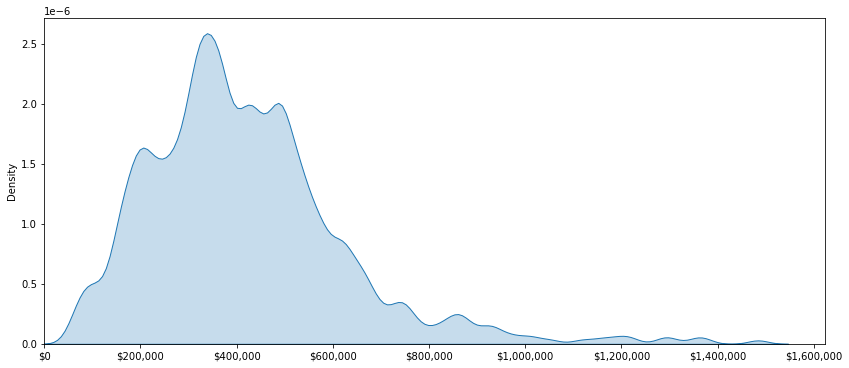

In [163]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(data["inflation_adjusted_pay"].values, shade=True, bw_method=.1)
helpers.set_money_axis(ax.xaxis)
ax.set_xlim(0, None)